### Imports

In [1]:
import pandas as pd
import seaborn as sns
import sys
import glob
import pathlib
from oak_cli.utils.logging import logger

from oak_cli.evaluation.graph_utils import PALETTE
from oak_cli.evaluation.addons.flops.graph_utils.keys import (
    RUN_ID_KEY,
    CPU_KEY,
    DISK_LAST_KEY,
    DISK_START_KEY,
    MEMORY_KEY,
    NETWORK_LAST_KEYS,
    NETWORK_START_KEYS,
    STAGE_KEY,
    TIME_START_KEY,
    ACCURACY_KEY,
    LOSS_KEY,
)
from oak_cli.evaluation.addons.flops.graph_utils.main import draw_graph
from oak_cli.evaluation.addons.flops.graph_utils.special_graphs import (
    draw_box_violin_plot_for_each_stage,
    draw_line_graph_with_all_runs,
    draw_trained_model_comparison_graph,
)

### Settings

In [2]:
USE_MINUTES = True

### Constants

In [3]:
#csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)
csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_mnist_sklearn_small_without_baseimages")
#csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_hierarchical_mnist_sklearn_small_without_baseimages")

### Data Loading

In [4]:
csv_files = glob.glob(f'{csv_dir}/evaluation_run_*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

#trained_model_df = pd.read_csv(TRAINED_MODEL_PERFORMANCE_CSV)
trained_model_df = pd.read_csv(csv_dir / "trained_models.csv")

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[TIME_START_KEY]] = df[[TIME_START_KEY]].astype(int)

df.set_index(TIME_START_KEY, inplace=True)

if USE_MINUTES:
    df.index = df.index / 60

singular_run_df = df[df[RUN_ID_KEY] == (df[RUN_ID_KEY].max() // 2)]

### Error Handing & Checking

In [5]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Common Graph Styling

In [6]:
sns.set_style("whitegrid")

---

# Graphs Drawing

### CPU & Memory

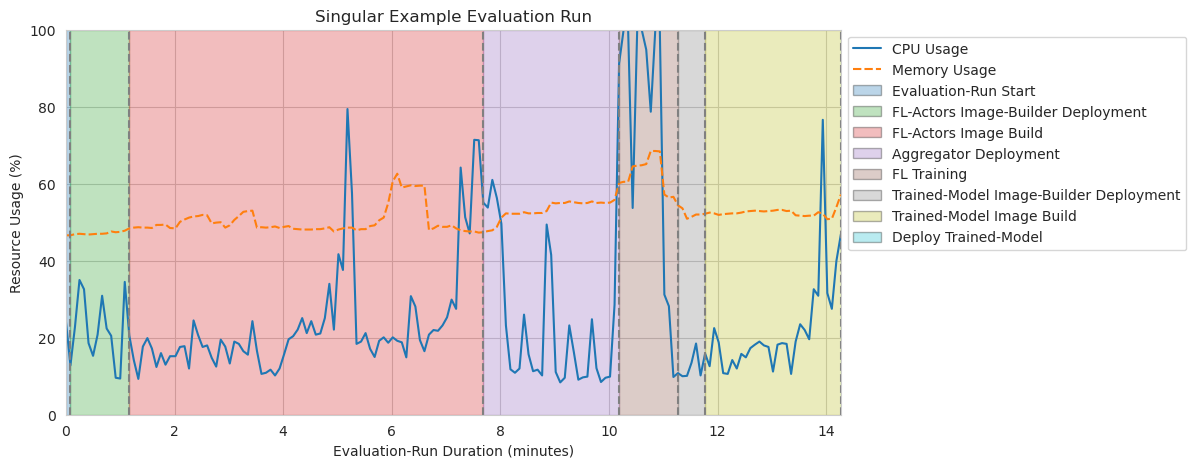

In [7]:
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    show_stages=True,
    use_percentage_limits=True,
)

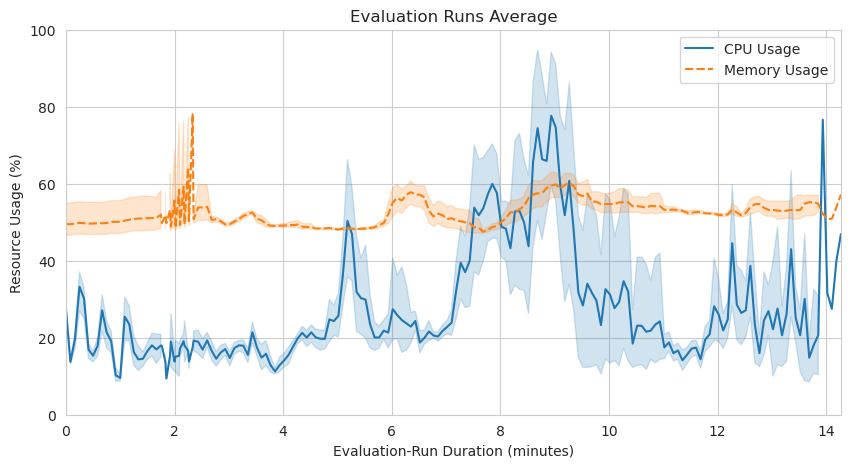

In [8]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    use_percentage_limits=True,
    #show_stages=True,
    #stages_color_intensity=0.01,
)

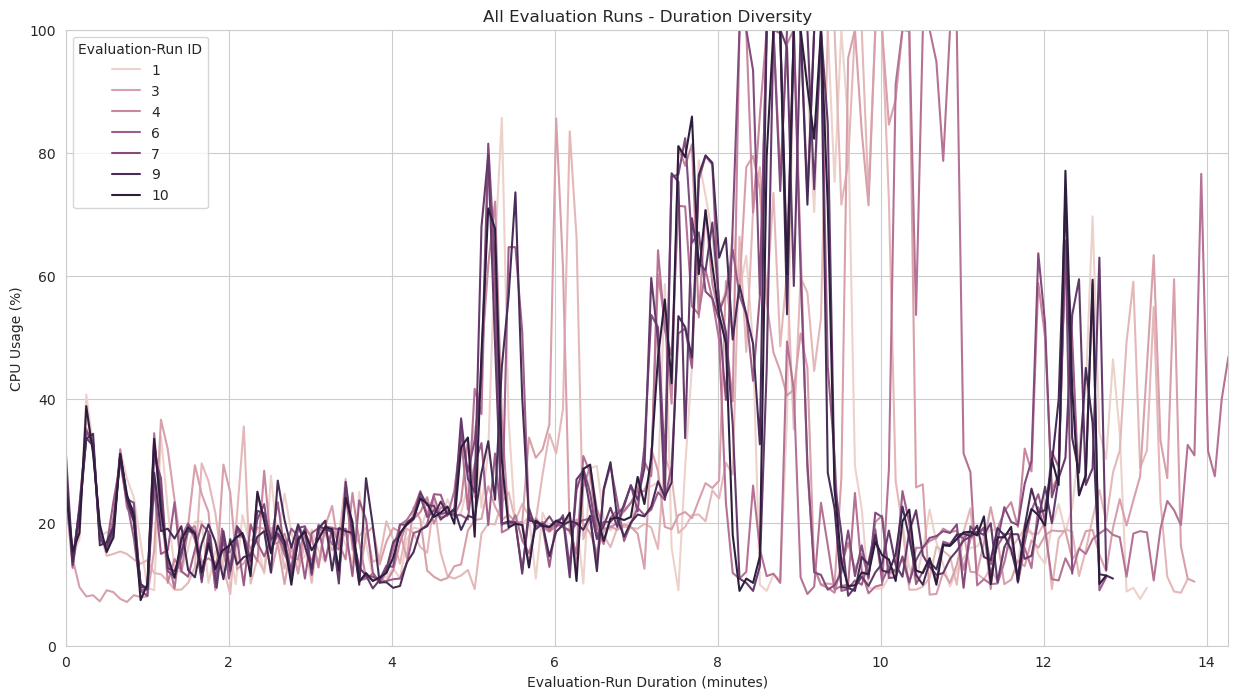

In [9]:
draw_line_graph_with_all_runs(
    data=df,
    y_label="CPU Usage (%)",
    key=CPU_KEY,
    )

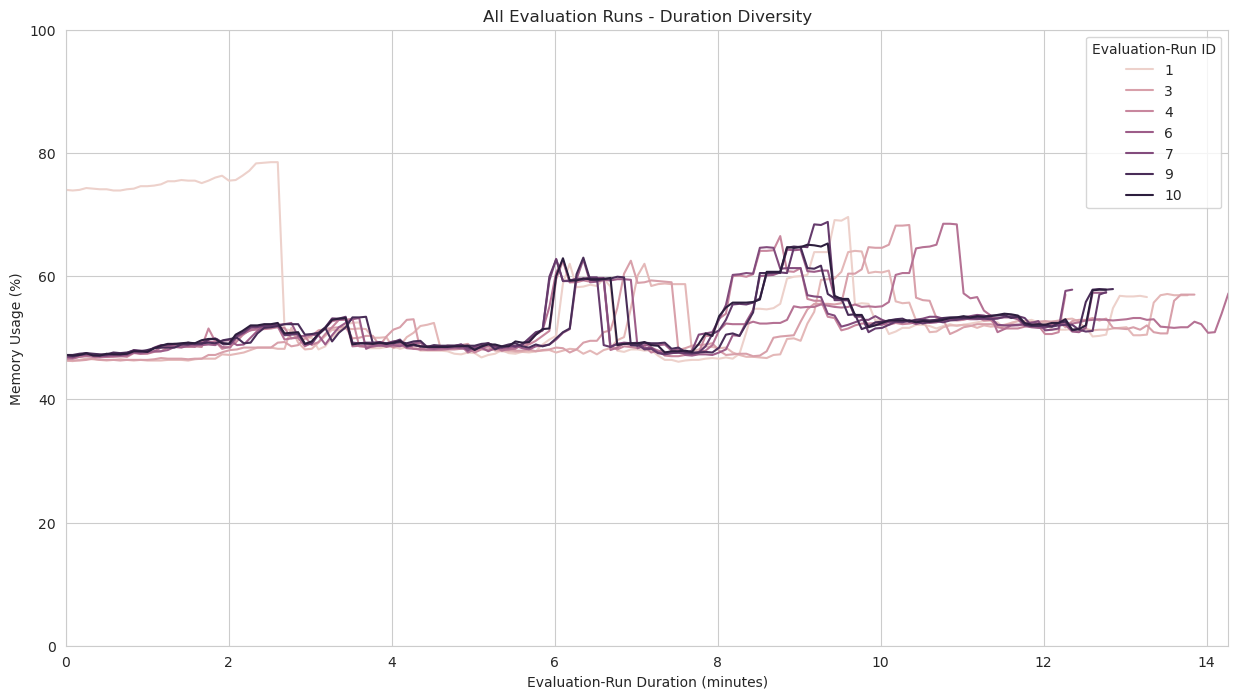

In [10]:
draw_line_graph_with_all_runs(
    data=df,
    y_label="Memory Usage (%)",
    key=MEMORY_KEY,
    )

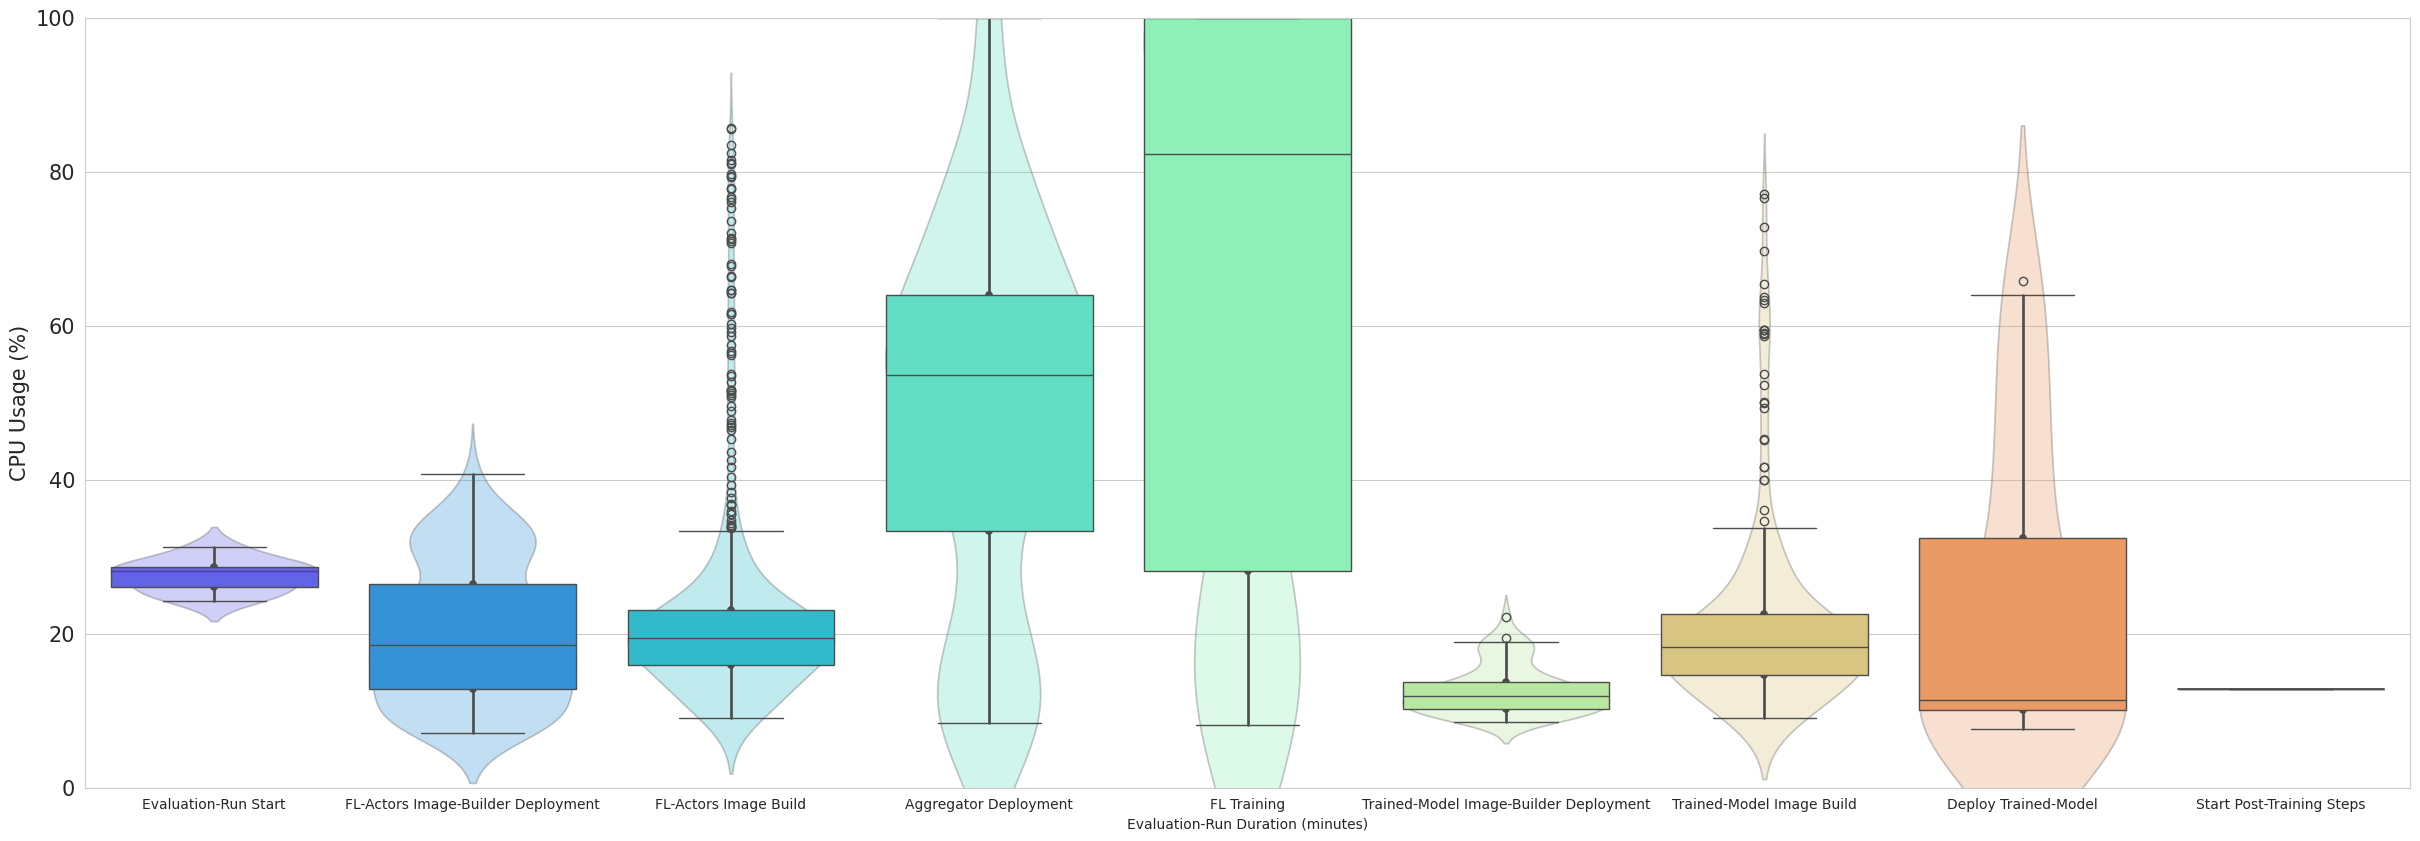

In [11]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=CPU_KEY,
    y_label="CPU Usage (%)",
    y_lim=(0,100),
)

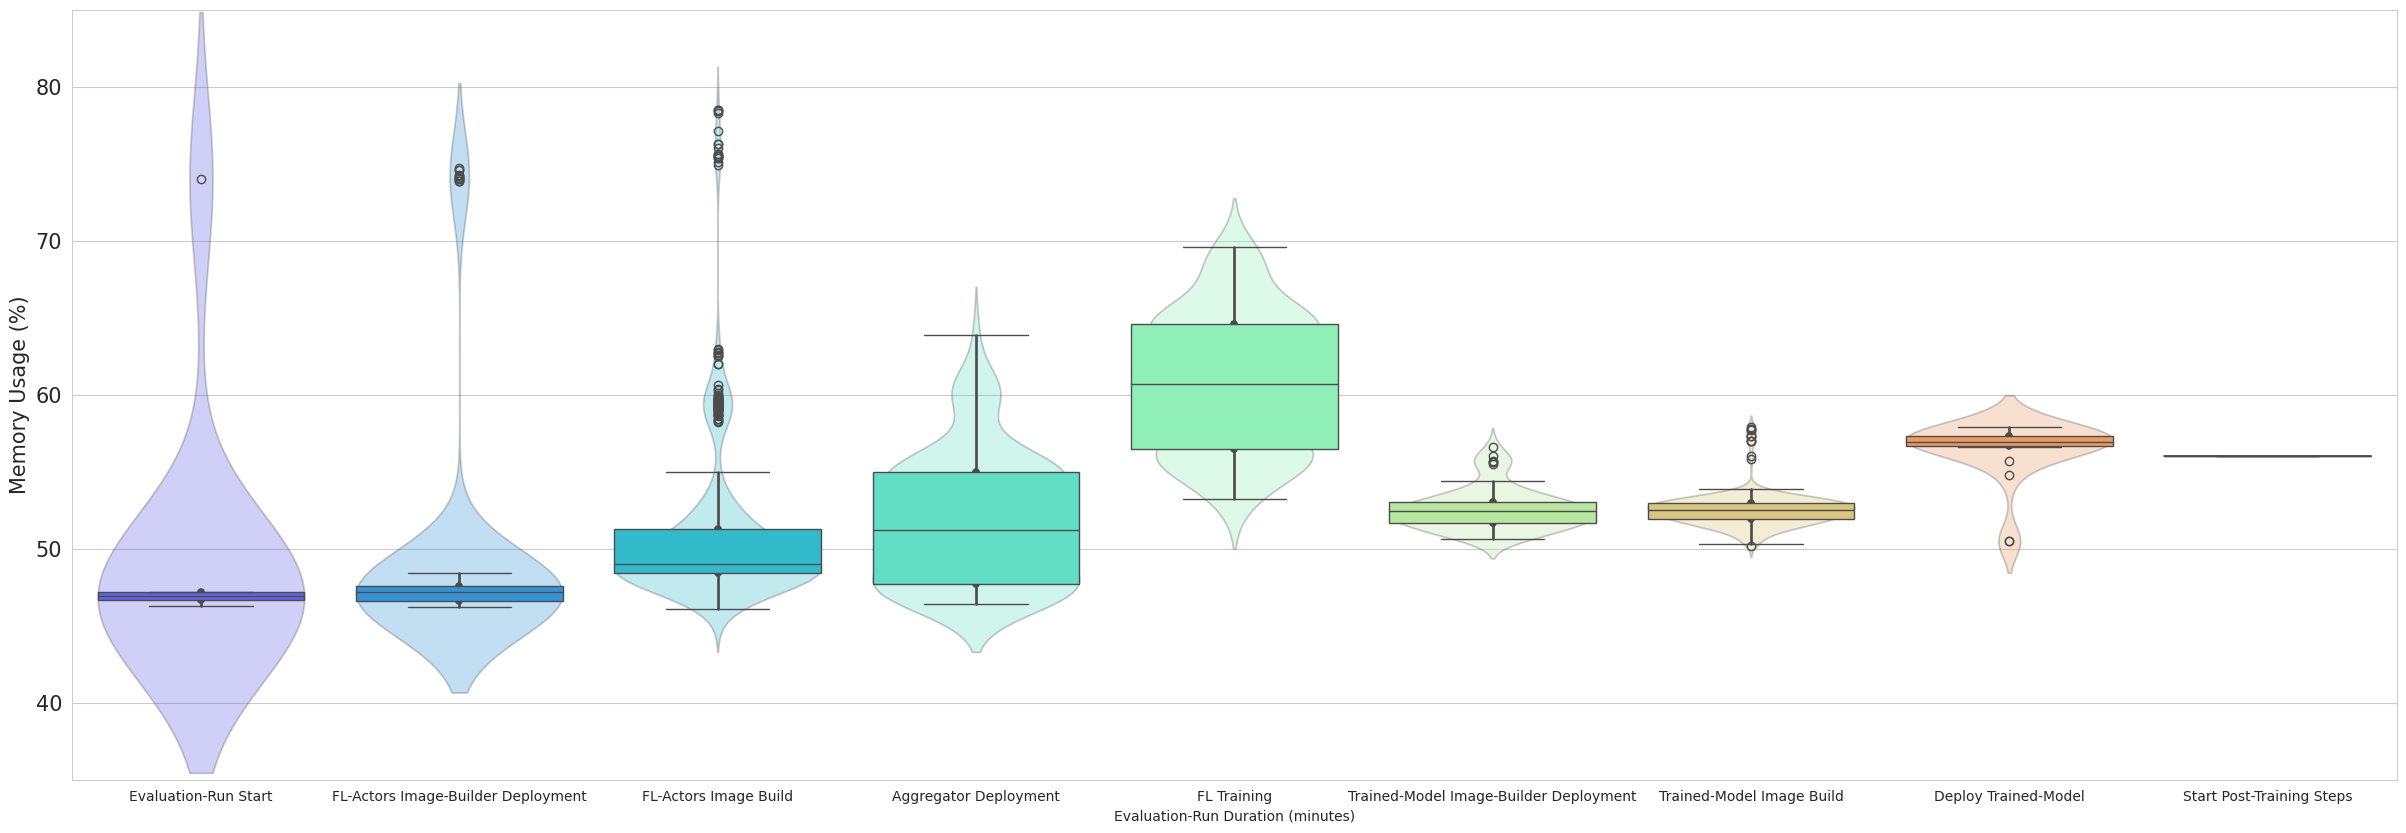

In [12]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=MEMORY_KEY,
    y_label="Memory Usage (%)",
    y_lim=(35,85)
)

In [24]:
draw_graph(
    size=(30,10),
    data=df,
    title="Stage Durations",
    plot_functions=[
        lambda: sns.countplot(
            x=STAGE_KEY,
            data=df,
            palette=PALETTE,
            hue=STAGE_KEY,
        )
    ],
    y_label = "Aggregated Count of Time Samples (All Runs) (Unit = 5 seconds)",
    y_axis_font_size_multiplier=1.5,
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2793948028.py, line 13)

### Disk Space Changes

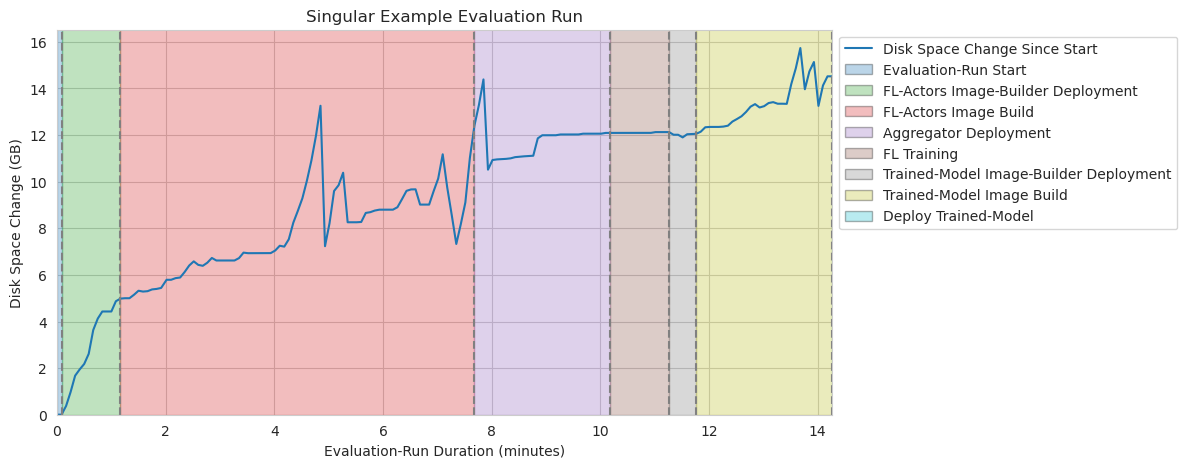

In [14]:
_singular_run_df = singular_run_df.copy()
_singular_run_df[[DISK_START_KEY]] = _singular_run_df[[DISK_START_KEY]] / 1024

draw_graph(
    title="Singular Example Evaluation Run",
    data=_singular_run_df[[DISK_START_KEY, STAGE_KEY]],
    y_label="Disk Space Change (GB)",
    x_lim=(0, max(_singular_run_df.index)),
    show_stages=True,
)

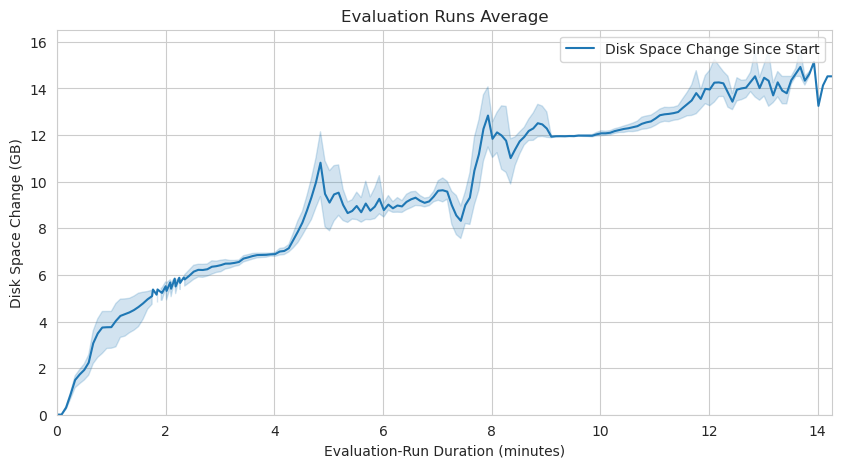

In [15]:
_df = df.copy()
_df[[DISK_START_KEY]] = _df[[DISK_START_KEY]] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_df[[DISK_START_KEY, STAGE_KEY]],
    y_label="Disk Space Change (GB)",
    x_lim=(0, max(_df.index)),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

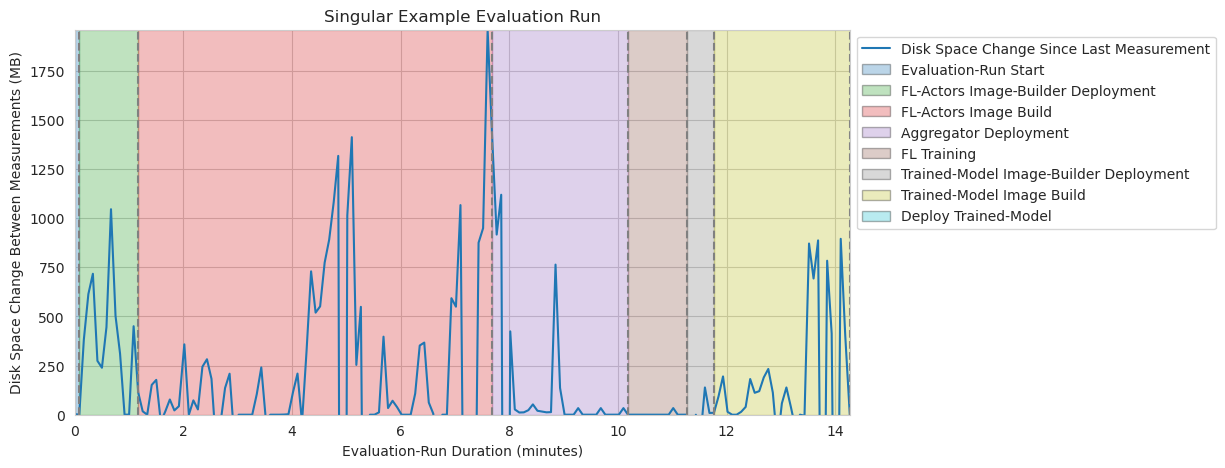

In [16]:

max_y = singular_run_df[DISK_LAST_KEY].max()
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    show_stages=True,
    stages_color_height=max_y,
    y_lim=(0, max_y)
)

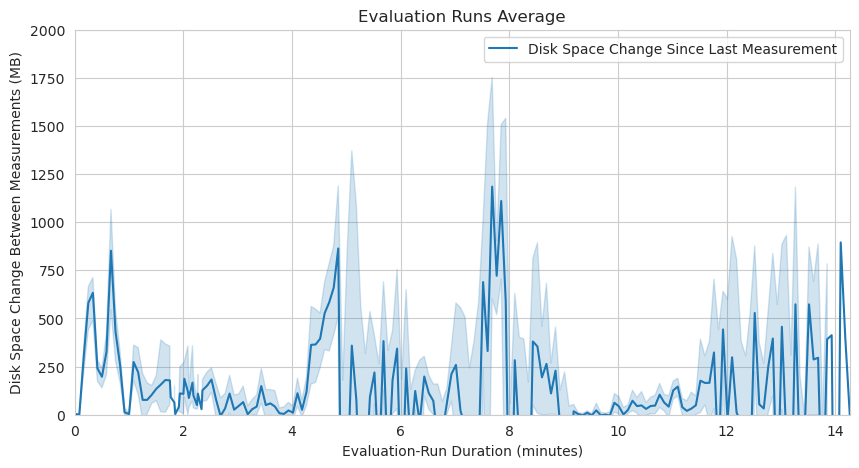

In [17]:
max_y = df[DISK_LAST_KEY].max()
draw_graph(
    title="Evaluation Runs Average",
    data=df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    #y_lim=(0, max_y),
    y_lim=(0, 2000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Network

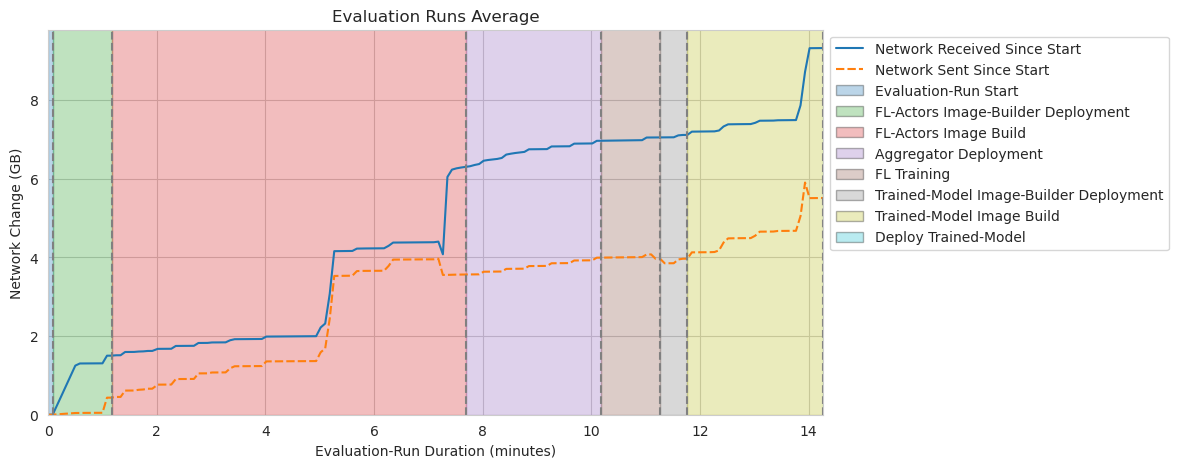

In [18]:
_singular_run_df = singular_run_df.copy()
_singular_run_df[NETWORK_START_KEYS] = _singular_run_df[NETWORK_START_KEYS] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_singular_run_df[NETWORK_START_KEYS + [STAGE_KEY]],
    y_label="Network Change (GB)",
    x_lim=(0, max(_singular_run_df.index)),
    show_stages=True,
)

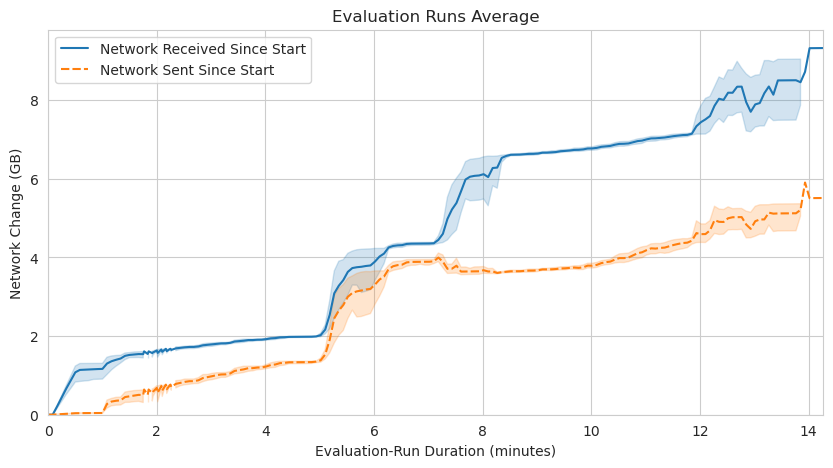

In [19]:
_df = df.copy()
_df[NETWORK_START_KEYS] = _df[NETWORK_START_KEYS] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_df[NETWORK_START_KEYS + [STAGE_KEY]],
    y_label="Network Change (GB)",
    x_lim=(0, max(_df.index)),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

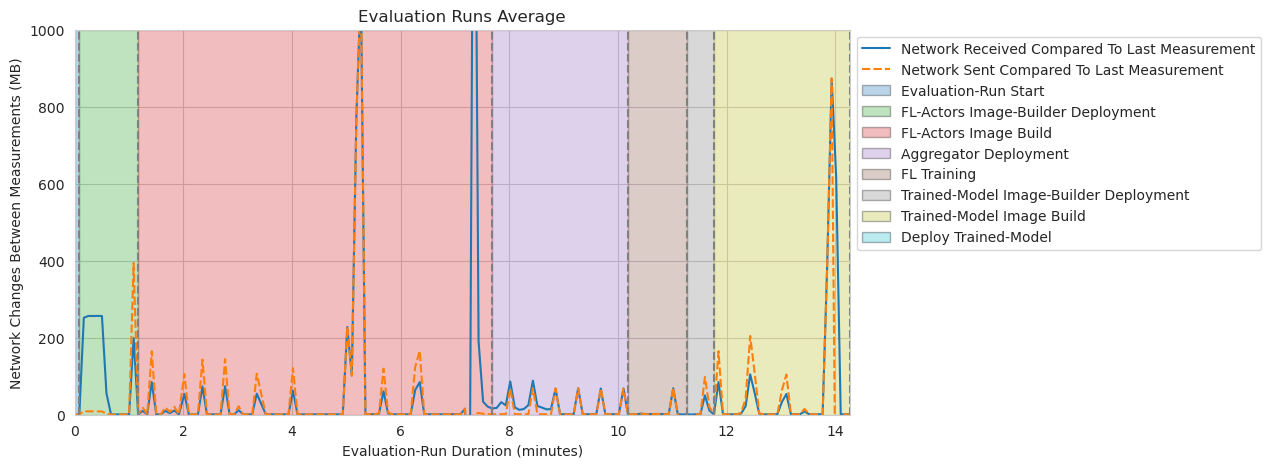

In [20]:
draw_graph(
    title="Evaluation Runs Average",
    data=singular_run_df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    y_lim=(0, 1000),
    show_stages=True,
    stages_color_height=1000
)

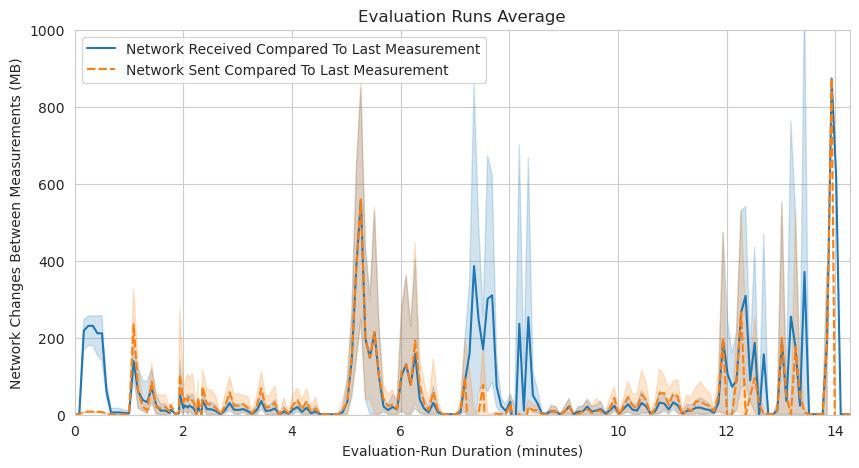

In [21]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    y_lim=(0, 1000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Trained Models

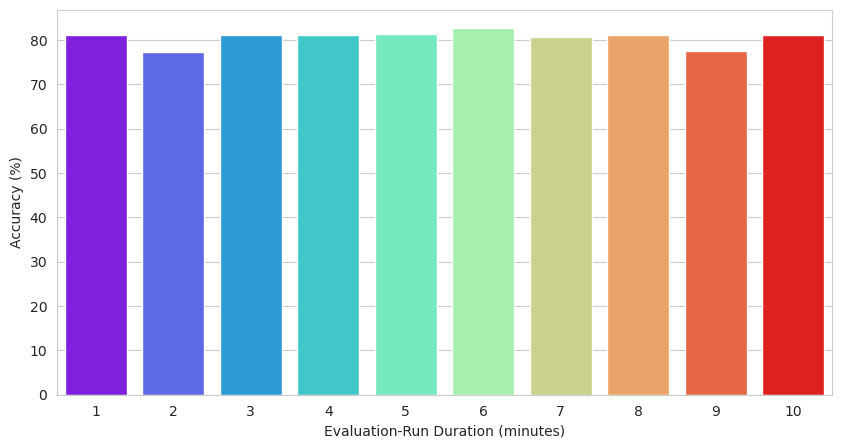

In [22]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=ACCURACY_KEY,
    y_label="Accuracy (%)"
)

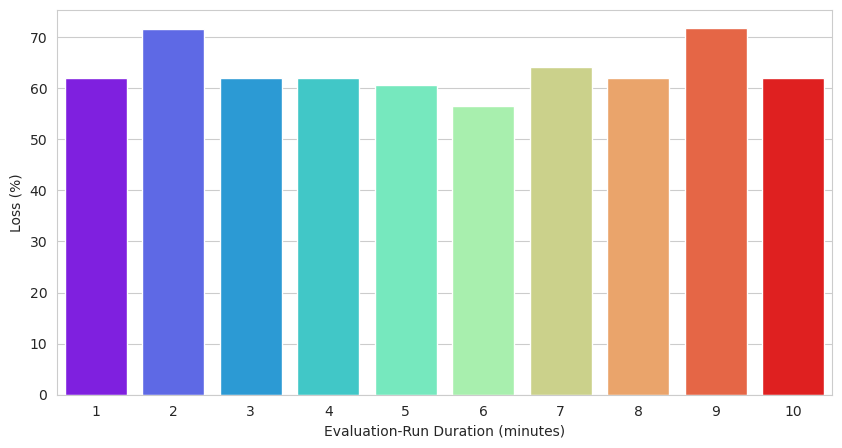

In [23]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=LOSS_KEY,
    y_label="Loss (%)"
)